# Leveraging BLIP for poor segmentation: demo

https://arxiv.org/html/2312.04539v1/

Some notebook links

 - [Setup](#Setup)

## Setup

In [1]:
# # install Rust for HF tokenizers
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

In [2]:
## Not really needed
# # install requirements
# import sys
# !RUSTUP_TOOLCHAIN=1.72.0 pip3 install -q transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install -q transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
#     !git clone https://github.com/salesforce/BLIP
#     %cd BLIP

In [3]:
# install requirements
import sys
!pip3 install -q transformers timm fairscale --upgrade

# # !RUSTUP_TOOLCHAIN=1.72.0 pip3 install -q transformers timm fairscale
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install -q transformers timm fairscale
#     !git clone https://github.com/salesforce/BLIP
#     %cd BLIP

In [4]:
%pip install torch-kmeans -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install spacy -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
!pip freeze

absl-py==2.1.0
aiohttp==3.9.5
aiosignal==1.3.1
annotated-types==0.7.0
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
awscrt==0.20.9
Babel==2.15.0
backoff==2.2.1
beautifulsoup4==4.12.3
bleach==6.1.0
blis==0.7.11
boto3==1.34.117
botocore==1.34.117
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpathlib==0.18.1
comm==0.2.2
confection==0.1.5
contourpy==1.2.1
cycler==0.12.1
cymem==2.0.8
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dnspython==2.6.1
email_validator==2.1.1
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
exceptiongroup==1.2.1
executing==2.0.1
fairscale==0.4.13
fastapi==0.111.0
fastapi-cli==0.0.4
fastjsonschema==2.19.1
filelock==3.14.0
fire==0.6.0
fonttools==4

In [1]:
import math
import matplotlib.pyplot as plt
import requests
import torch

from PIL import Image
from skimage import color
from skimage import io
from torch_kmeans import KMeans
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
from typing import Dict, Tuple

Sample image

In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
# http://images.cocodataset.org/val2017/000000039769.jpg
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

## Wprawka

### No model działa :)

Czy chcemy embeddować patche niezależnie, czy razem (chyba tak, bo mamy Multi-head attention).
Oczywiście, że razem

Text generation

In [3]:
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration

processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# conditional image captioning
text = "a photography of"
inputs = processor_s(image, text, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor_s(image, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a woman sitting on the beach with her dog

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog


Tokens

In [4]:
out

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102]])

## Mięso

In [5]:
# Let's assume that the preprocessing is essentially the same for the base and large models
# and we can use the same processor for both, but we will create two for different image sizes
def get_models():
    processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    processor_l = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", size={"height": 512, "width": 512}) # the altered size would also work with the small model
    model_l = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

    return processor_s, model_s, processor_l, model_l

In [6]:
processor_s, model_s, processor_l, model_l = get_models()

In [7]:
processor_s

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[S

In [8]:
processor_l

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-large', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_token

In [9]:
@torch.no_grad()
def get_kmeans_cluster_assignments(models: Dict[str, Tuple[BlipProcessor, BlipForConditionalGeneration]], image, ks=(2, 8)) -> Dict[str, Tuple[torch.Tensor, torch.Tensor]]:
    result = {}
    for model_processor_pair_name, (processor, blip) in models.items():
        for k in ks:
            print(f"{k=}")
            inputs = processor(image, return_tensors="pt")
            input_image_batch = inputs['pixel_values']

            # TODO see model.get_image_features
            vision_out = blip.vision_model(input_image_batch, return_dict=True, interpolate_pos_encoding=True) # important to interpolate the positional encoding! # TODO can we always do that?

            # seems we have 576 (24*24) or 1024 (32*32) patches
            encoded_tokens = vision_out.last_hidden_state[:, 1:, :] # [bs, num_patches, hidden_size]/[bs, 576, 768] # discard the hidden state for the CLS token
            ntoken = encoded_tokens.shape[1] # the shape is [bs, ntoken, embedding_dim]
            patch_size = 16 # let's just assume that this is what we have in the model instead of passing this as a parameter that would never be changed
            image_size_in_patches = int(math.sqrt(ntoken)) # 24 for the small model (24x24 16x16 patches gives 384x384 image size)

            kmeans = KMeans(n_clusters=k) #, distance='cosine') # worth trying cosine distance
            cluster_assignments = kmeans(encoded_tokens)

            # upscale the cluster assignments to the original image resolution
            upscaled_cluster_assignments = cluster_assignments.labels.view(image_size_in_patches, image_size_in_patches).repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)

            result[f"{model_processor_pair_name}, {k=}"] = (input_image_batch[0], upscaled_cluster_assignments)
    return result

In [10]:
def visualize_clusters(pixel_cluster_assignments: Dict[str, Tuple[torch.Tensor, torch.Tensor]]):
    plot_nrow = math.ceil(len(pixel_cluster_assignments) / 2)
    plot_size = 7
    plt.figure(figsize=(plot_size * 2, plot_size * plot_nrow))

    plt.title("Cluster assignments for different model sizes, image sizes and number of clusters", pad=(plot_size * 7))
    plt.axis('off')

    for i, (cluster_assignment_title, (input_image, pixel_cluster_assignment)) in enumerate(pixel_cluster_assignments.items()):
        # we can't do this once, as the image sizes are not uniform
        mean = torch.tensor((0.48145466, 0.4578275, 0.40821073))
        std = torch.tensor((0.26862954, 0.26130258, 0.27577711))
        denormalize = transforms.Normalize(
            mean = -mean/std,
            std = 1.0 / std
        )

        original_image = denormalize(input_image).permute(1, 2, 0).numpy()

        ax = plt.subplot2grid((plot_nrow, 2), (i// 2, i % 2))
        ax.axis('off')
        ax.set_title(cluster_assignment_title)
        ax.imshow(color.label2rgb(pixel_cluster_assignment.numpy(), original_image, bg_label=666)) # there's no background label (yet ;))
    
    plt.show()

k=2


Full batch converged at iteration 16/100 with center shifts = tensor([0.]).
k=8
Full batch converged at iteration 28/100 with center shifts = tensor([0.]).
k=2
Full batch converged at iteration 25/100 with center shifts = tensor([0.]).
k=8
Full batch converged at iteration 24/100 with center shifts = tensor([0.]).
k=2
Full batch converged at iteration 13/100 with center shifts = tensor([0.]).
k=8
Full batch converged at iteration 16/100 with center shifts = tensor([0.]).
k=2
Full batch converged at iteration 18/100 with center shifts = tensor([0.]).
k=8
Full batch converged at iteration 23/100 with center shifts = tensor([0.]).


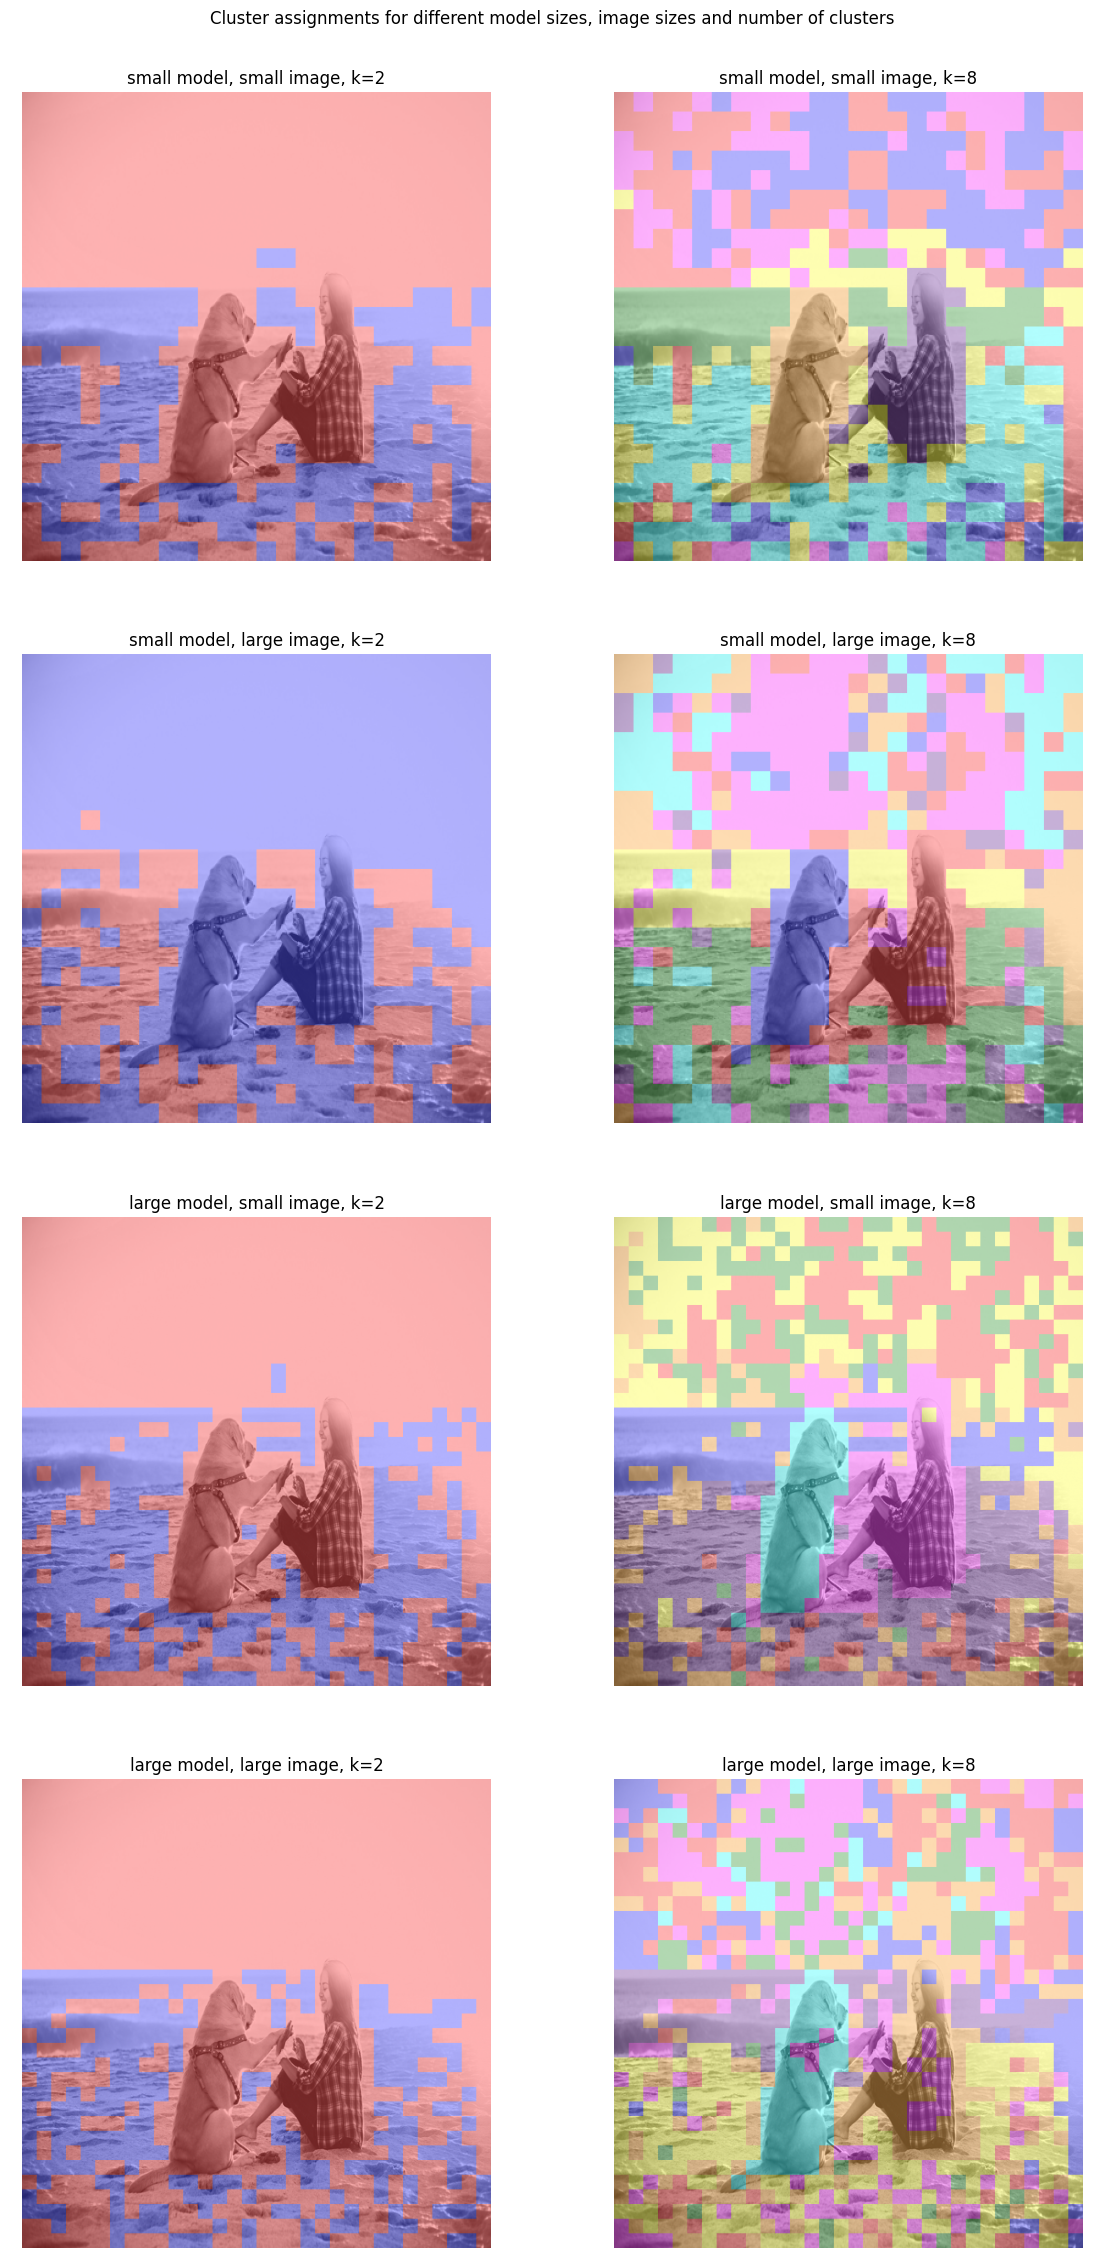

In [11]:
plot_data = get_kmeans_cluster_assignments(
    {
        'small model, small image': (processor_s, model_s),
        'small model, large image': (processor_s, model_l),
        'large model, small image': (processor_l, model_s),
        'large model, large image': (processor_l, model_l),
    },
    image,
    ks=(2, 8)
)
visualize_clusters(plot_data)

### Patch embeddings (large)

### Clustering

### Cluster Alignment

### Denoising

### Noun Generation by filtering BLIP Decoder output from the clusters

In [12]:
import spacy
# from spacy.lang.en.examples import sentences

nlp = spacy.load("en_core_web_sm")
# doc = nlp(sentences[0])
# print(doc.text)
# for token in doc:
#     print(token.text, token.pos_, token.dep_)

# # now filter nouns from the document
# nouns = [token.text for token in doc if token.pos_ == "NOUN"]
# print(nouns)

doc = nlp('Ala has an awful cat that has some fur')
nouns = [token.text for token in doc if token.pos_ == "NOUN"]
print(nouns)

['cat', 'fur']


### Forwarding Generated Nouns to the Segmentor

### Evaluation?